#### Load libraries

In [2]:
library(tidyverse)
library(data.table)
library(dendextend)
library(reshape2)
suppressMessages(library(pheatmap))
library(RColorBrewer)
library(gridExtra)
source("../../0_metadata/theme_CRP-MISC.R")

###----------------------------------

PVAL_THRESH = 0.05
LOGFC_THRESH = 0.01

###----------------------------------

annotation <- fread(file="../../0_metadata/gencode.biotype.name.key.tsv")

#### Load Functions

In [3]:
colLab<<-function(n,metadata){
    if(is.leaf(n)){
        
#         print(attributes(n)$label)
        
        #I take the current attributes
        a=attributes(n)
        
        #I deduce the line in the original data, and so the treatment and the specie.
        ligne=match(attributes(n)$label,rownames(metadata))
        Diagnosis=metadata[ligne,]$Diagnosis;
            if(Diagnosis=="COVID-19"){col_diag="#F0484E"};if(Diagnosis=="MIS-C"){col_diag="#5CB2EB"};if(Diagnosis=="Control_Non-inflammatory"){col_diag="#FBE77C"};if(Diagnosis=="Control_Inflammatory"){col_diag="purple"}
        #Modification of leaf attribute
        attr(n,"nodePar")<-c(a$nodePar,list(cex=1.5,lab.cex=1,pch=15,col=col_diag,lab.col=col_diag,lab.font=1,lab.cex=1))
        }
    return(n)
}


get_gene_id <- function(X,annotation){
    return(annotation[which(annotation$gene_name == X),]$gene_id)
    }


get_dend <- function(IDS,sig_genes,meta,ftcounts){
    
    ANNOTATIONS <- c("Diagnosis","severity",'pcr_positive_MC_1yes','antibody_positive_MC_1yes','kd_like_MC_1yes','req_vasopressors_inotropes_MC_1yes')

    if (is.null(meta$cfrna_file_id)) {meta$cfrna_file_id <- meta$SEQ_ID..UCSFonly.}
    
    metadata <- meta %>% 
    filter(cfrna_file_id %in% all_of(IDS)) %>%                                 ###
    mutate(PTID_DATE = gsub("-","\\.",PTID_DATE)) %>%
    column_to_rownames(var = "PTID_DATE") %>%  
    mutate(severity = ifelse(grepl("ontrol",severity),NA,severity)) %>%
    select(all_of(ANNOTATIONS))

    colnames(metadata) <- c("Diagnosis","Severity","PCR","Antibody")

    ###----------------------------------
    ## Subset count matrix
    mat <- data.frame(ftcounts) %>% 
            filter(row.names(ftcounts) %in% all_of(sig_genes)) %>% 
            select(all_of(rownames(metadata))) %>% 
            as.matrix()

    mat <- t(scale(t(mat)))

    ###----------------------------------
    ## Perform clustering

    h <- hclust(as.dist(1 - cor(mat, method = "pearson", use = 'pairwise.complete.obs')))
#     h <- hclust(as.dist(mat))

    dend <- as.dendrogram(h)

    dendL <- dendrapply(dend, colLab,metadata)

    return(dendL)
}


make_dend_list <- function(cf_tmp_rds, wb_tmp_res, 
                           cf_meta, wb_meta,
                           cf_ftcounts,wb_ftcounts,
                           PVAL_THRESH = PVAL_THRESH, LOGFC_THRESH = LOGFC_THRESH,N=0){
    
    #----------------------------------------
    ## Cell-free
    IDS_cf <- colnames(cf_tmp_rds[['dds']])
    if (N>0){IDS_cf <- sample(IDS_cf,N)}

    sig_genes_cf <- data.frame(cf_tmp_rds[['res']]) %>% filter(padj < PVAL_THRESH & abs(log2FoldChange) > LOGFC_THRESH) %>% rownames()
    cf_dendL = get_dend(IDS_cf,sig_genes_cf,cf_meta,cf_ftcounts)

    #----------------------------------------
    ## Whole blood
    wb_tmp_res$ensmbl <- lapply(wb_tmp_res$gene,get_gene_id,annotation)

    cf_pt_dates <- cf_meta %>% filter(cfrna_sample_id %in% all_of(IDS_cf)) %>% pull(PTID_DATE)

    IDS_wb <- wb_meta %>% 
        filter(PTID_DATE %in% all_of(cf_pt_dates)) %>% 
        pull(SEQ_ID..UCSFonly.)

    sig_genes_wb <- wb_tmp_res %>% filter(padj < PVAL_THRESH & abs(log2FoldChange) > LOGFC_THRESH) %>% pull(gene)
    wb_dendL = get_dend(IDS_wb,sig_genes_wb,wb_meta,wb_ftcounts)
    
    return(dendlist(cf_dendL,wb_dendL))
}


get_pval <- function(dendlist,the_cor,R){
    
    set.seed(42)
    
    cor_bakers_gamma_results <- numeric(R)
    
    d1 <- dendlist[[1]]
    d2 <- dendlist[[2]]
    
    for(i in 1:R) {
       dend_mixed <- sample.dendrogram(d2, replace = FALSE)
       cor_bakers_gamma_results[i] <- cor_bakers_gamma(d1, dend_mixed)
    }
    
    if(sum(the_cor < cor_bakers_gamma_results)==0){return("ALL BELOW")}
    
    pval <- sum(the_cor < cor_bakers_gamma_results)/ R
                  
    return(pval)

}

get_conf <- function(dendlist,the_cor,R){

    set.seed(42)
    
    dend1 <- dendlist[[1]]
    dend2 <- dendlist[[2]]

    dend1_labels <- labels(dend1)
    dend2_labels <- labels(dend2)
    cor_bakers_gamma_results <- numeric(R)
    
    for(i in 1:R) {
       sampled_labels <- sample(dend1_labels, replace = TRUE)
       # members needs to be fixed since it will be later used in nleaves
       dend_mixed1 <- sample.dendrogram(dend1, 
                                        dend_labels=dend1_labels,
                                        fix_members=TRUE,fix_order=TRUE,fix_midpoint=FALSE,
                                        replace = TRUE, sampled_labels=sampled_labels
                                          )
       dend_mixed2 <- sample.dendrogram(dend2, dend_labels=dend2_labels,
                                        fix_members=TRUE,fix_order=TRUE,fix_midpoint=FALSE,
                                        replace = TRUE, sampled_labels=sampled_labels
                                          )                                    
       cor_bakers_gamma_results[i] <- cor_bakers_gamma(dend_mixed1, dend_mixed2, warn = FALSE)
    }


    CI95 <- quantile(cor_bakers_gamma_results, probs=c(.025,.975))
    
    return(CI95)
}

#### Load outputs

In [5]:
# cf_covid_cntrl <- readRDS("../../1_cfRNA/DAA/comparisons_to_controls_ftcount/2_ALL-results.rds")
# cf_misc_cntrl <- readRDS("../../1_cfRNA/DAA/comparisons_to_controls_ftcount/3_ALL-results.rds")
# cf_misc_covid <- readRDS("../../1_cfRNA/DAA/comparisons_to_controls_ftcount/5_ALL-results.rds")

cf_covid_cntrl <- readRDS("./subset_CF/2_ALL-results.rds")
cf_misc_cntrl <- readRDS("./subset_CF/3_ALL-results.rds")
cf_misc_covid <- readRDS("./subset_CF/5_ALL-results.rds")

wb_covid_cntrl <- read.delim("./subset_WB/paired_wb_covid_ctrls.txt")
wb_misc_cntrl <- read.delim("./subset_WB/paired_wb_misc_ctrls.txt")
wb_misc_covid <- read.delim("./subset_WB/paired_wb_misc_covid.txt")

PatientDate_df <- read.delim("/workdir/cjl332/prevail/meta_data/patient-date_df.tsv") %>% mutate(PTID_DATE = gsub("\\-",".",paste0(PTID,"_",Date)))

#### Load Whole Blood

In [8]:
#------------------------
## READ OUTPUTS

wb_meta <- read.delim("../../0_metadata/wbrna.tsv") %>% 
    filter(sample_group_matched != -1)
#     filter(Coverage..10...0.no..1.yes..NA.not.applicable.or.sample.not.available. == '1') %>%
#     mutate(PTID_DATE = paste0(PTID,"_",Date))

# wb_meta <- wb_meta[match(unique(wb_meta$PTID_DATE), wb_meta$PTID_DATE),]

wb_ftcounts <- read.delim("../../1_sample-output/wbrna_ftcounts.txt") %>% 
# wb_ftcounts <- read.delim("../../3_wbRNA/misc72_cnh19_covid37_ctrls26_counts.txt") %>% 
    rename(gene_id = X) %>% 
    mutate(gene_id = gsub("\\_.*","",gene_id)) %>%
    distinct(gene_id, .keep_all = TRUE) %>%
    column_to_rownames(var = "gene_id")


# wb_meta <- wb_meta[which(wb_meta$SEQ_ID..UCSFonly. %in% colnames(wb_ftcounts)),]
#------------------------
## FILTER

globin = c('HBA1','HBA2','HBB','HBBP1','HBD',
     'HBE1','HBG1','HBG2','HBM','HBQ1',
     'HBZ','HBZP1')
globin = annotation %>% filter(gene_name %in% all_of(globin)) %>% pull(gene_id) 

gene.list <- read.delim("../../0_metadata/genelist.hs.tsv",col.names = c("type,","ENSMBL","gene_symbol"))
gene.ids_wb <- gsub("\\..*","",rownames(wb_ftcounts))
exclude.idx_wb <- gene.ids_wb %in% c(gene.list[,2], globin)
wb_ftcounts = wb_ftcounts[!exclude.idx_wb,] 

wb_ftcounts <- wb_ftcounts[,colSums(wb_ftcounts) > 0]
#------------------------
## NORMALIZE

wb_ftcounts <- edgeR::cpm(wb_ftcounts)


#------------------------
## RENAME

wb_ftcounts <- wb_ftcounts[,colnames(wb_ftcounts) %in% wb_meta$SEQ_ID..UCSFonly.]
wb_ids <- colnames(wb_ftcounts)
wb_ptid_dates <- wb_meta %>% filter(SEQ_ID..UCSFonly. %in% wb_ids) %>% arrange(factor(SEQ_ID..UCSFonly., levels = wb_ids)) %>% pull(PTID_DATE)
colnames(wb_ftcounts) <- wb_ptid_dates

#### Load Cell-Free

In [9]:
#------------------------
## READ OUTPUTS

cf_meta <-read.delim("../../0_metadata/cfrna.tsv") %>% filter(passQC_1yes_.1no == 1) %>% 
    filter(sample_group_matched != -1)

cf_ftcounts <- read.delim("../../1_sample-output/cfrna_ftcounts.txt") %>%
    rename(gene_id = Geneid) %>% 
    mutate(gene_id = gsub("\\_.*","",gene_id)) %>%
    distinct(gene_id, .keep_all = TRUE) %>%
    column_to_rownames(var = "gene_id")

# cf_meta <- cf_meta[which(cf_meta$cfrna_file_id %in% colnames(cf_ftcounts)),]

#------------------------
## FILTER

globin = c('HBA1','HBA2','HBB','HBBP1','HBD',
     'HBE1','HBG1','HBG2','HBM','HBQ1',
     'HBZ','HBZP1')
globin = annotation %>% filter(gene_name %in% all_of(globin)) %>% pull(gene_id) 

gene.list <- read.delim("../../0_metadata/genelist.hs.tsv",col.names = c("type,","ENSMBL","gene_symbol"))

gene.ids_cf <- gsub("\\..*","",rownames(cf_ftcounts))
exclude.idx_cf <- gene.ids_cf %in% c(gene.list[,2], globin)
cf_ftcounts = cf_ftcounts[!exclude.idx_cf,] 


#------------------------
## NORMALIZE
cf_ftcounts <- edgeR::cpm(cf_ftcounts)


#------------------------
## RENAME

cf_ftcounts <- cf_ftcounts[,colnames(cf_ftcounts) %in% cf_meta$cfrna_file_id]
cf_ids <- colnames(cf_ftcounts)
cf_ptid_dates <- cf_meta %>% filter(cfrna_file_id %in% cf_ids) %>% arrange(factor(cfrna_file_id, levels = cf_ids)) %>% pull(PTID_DATE)
colnames(cf_ftcounts) <- cf_ptid_dates

----
----
---
## Universal Code

#### __MIS-C and COVID-19__

In [10]:
PVAL_THRESH = 0.05
LOGFC_THRESH = 1

In [11]:
###----------------------------------
# MIS-C and COVID
dendlist <- make_dend_list(cf_misc_covid, wb_misc_covid, 
                           cf_meta, wb_meta,
                           cf_ftcounts,wb_ftcounts,
                           PVAL_THRESH = PVAL_THRESH, LOGFC_THRESH = LOGFC_THRESH)

bg_cor <- cor_bakers_gamma(dendlist[[1]],dendlist[[2]])
pval <- get_pval(dendlist,bg_cor,1000)

print(bg_cor)
print(pval)

HEIGHT = 1
WIDTH = 3

pdf(file="plots/panelC_misc-covid.pdf",
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

dendlist %>% 
    tanglegram(intersecting= TRUE,color_lines = "black",
                           margin_inner = 0.1,
             highlight_branches_lwd = FALSE,
             highlight_distinct_edges = FALSE,
             lwd = 0.5,
               edge.lwd = 0.8,
             margin_top=0,
             margin_bottom = 2)

dev.off()

[1] 0.1067597
[1] 0.022


png 
  2

#### __MIS-C and CONTROL__

In [12]:
###----------------------------------
# MIS-C and Control
dendlist <- make_dend_list(cf_misc_cntrl, wb_misc_cntrl, 
                           cf_meta, wb_meta,
                           cf_ftcounts,wb_ftcounts,
                           PVAL_THRESH = PVAL_THRESH, LOGFC_THRESH = LOGFC_THRESH)

bg_cor <- cor_bakers_gamma(dendlist[[1]],dendlist[[2]])
pval <- get_pval(dendlist,bg_cor,1000)

print(bg_cor)
print(pval)


pdf(file="plots/panelC_misc-control.pdf",
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

dendlist %>% 
    tanglegram(intersecting= TRUE,color_lines = "black",
                           margin_inner = 0.1,
             highlight_branches_lwd = FALSE,
             highlight_distinct_edges = FALSE,
             lwd = 0.5,
               edge.lwd = 0.8,
             margin_top=0,
             margin_bottom = 2)
dev.off()



[1] 0.5995991
[1] "ALL BELOW"


png 
  2

#### __COVID-19 and CONTROL__

In [13]:
###----------------------------------
# COVID and Control
dendlist <- make_dend_list(cf_covid_cntrl, wb_covid_cntrl, 
                           cf_meta, wb_meta,
                           cf_ftcounts,wb_ftcounts,
                           PVAL_THRESH = PVAL_THRESH, LOGFC_THRESH = LOGFC_THRESH)

bg_cor <- cor_bakers_gamma(dendlist[[1]],dendlist[[2]])
pval <- get_pval(dendlist,bg_cor,1000)

print(bg_cor)
print(pval)


pdf(file="plots/panelC_covid-control.pdf",
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

dendlist %>% 
    tanglegram(intersecting= TRUE,color_lines = "black",
                           margin_inner = 0.1,
             highlight_branches_lwd = FALSE,
             highlight_distinct_edges = FALSE,
             lwd = 0.5,
               edge.lwd = 0.8,
             margin_top=0,
             margin_bottom = 2)
dev.off()

[1] 0.6363784
[1] "ALL BELOW"


png 
  2

In [1]:
library(tidyverse)
library(data.table)
library(dendextend)
library(reshape2)
suppressMessages(library(pheatmap))
library(RColorBrewer)
library(gridExtra)

set.seed(42)

###----------------------------------

PVAL_THRESH = 0.05
LOGFC_THRESH = 1


###----------------------------------

annotation <- fread(file="../../0_metadata/gencode.biotype.name.key.tsv")

#----------------------------------------------------------------------------------------------
# FUNCTIONS 
#----------------------------------------------------------------------------------------------

colLab<<-function(n,metadata){
    if(is.leaf(n)){
        
#         print(attributes(n)$label)
        
        #I take the current attributes
        a=attributes(n)
        
        #I deduce the line in the original data, and so the treatment and the specie.
        ligne=match(attributes(n)$label,rownames(metadata))
        Diagnosis=metadata[ligne,]$Diagnosis;
            if(Diagnosis=="COVID-19"){col_diag="#740C33"};if(Diagnosis=="MIS-C"){col_diag="#0234C1"};if(Diagnosis=="Control_Non-inflammatory"){col_diag="#4b7a47"};if(Diagnosis=="Control_Inflammatory"){col_diag="purple"}
        #Modification of leaf attribute
        attr(n,"nodePar")<-c(a$nodePar,list(cex=1.5,lab.cex=1,pch=15,col=col_diag,lab.col=col_diag,lab.font=1,lab.cex=1))
        }
    return(n)
}


get_gene_id <- function(X,annotation){
    return(annotation[which(annotation$gene_name == X),]$gene_id)
    }


get_dend <- function(IDS,sig_genes,meta,ftcounts){
    
    ANNOTATIONS <- c("Diagnosis","severity",'pcr_positive_MC_1yes','antibody_positive_MC_1yes','kd_like_MC_1yes','req_vasopressors_inotropes_MC_1yes')

    if (is.null(meta$cfrna_file_id)) {meta$cfrna_file_id <- meta$SEQ_ID..UCSFonly.}
    
    metadata <- meta %>% 
    filter(cfrna_file_id %in% all_of(IDS)) %>%                                 ###
    mutate(PTID_DATE = gsub("-","\\.",PTID_DATE)) %>%
    column_to_rownames(var = "PTID_DATE") %>%  
    mutate(severity = ifelse(grepl("ontrol",severity),NA,severity)) %>%
    select(all_of(ANNOTATIONS))

    colnames(metadata) <- c("Diagnosis","Severity","PCR","Antibody")

    ###----------------------------------
    ## Subset count matrix
    mat <- data.frame(ftcounts) %>% 
            filter(row.names(ftcounts) %in% all_of(sig_genes)) %>% 
            select(all_of(rownames(metadata))) %>% 
            as.matrix()

    mat <- t(scale(t(mat)))

    ###----------------------------------
    ## Perform clustering

    h <- hclust(as.dist(1 - cor(mat, method = "pearson", use = 'pairwise.complete.obs')))
#     h <- hclust(as.dist(mat))

    dend <- as.dendrogram(h)

    dendL <- dendrapply(dend, colLab,metadata)

    return(dendL)
}


make_dend_list <- function(cf_tmp_rds, wb_tmp_res, 
                           cf_meta, wb_meta,
                           cf_ftcounts,wb_ftcounts,
                           PVAL_THRESH = PVAL_THRESH, LOGFC_THRESH = LOGFC_THRESH,N=0){
    
    #----------------------------------------
    ## Cell-free
    IDS_cf <- colnames(cf_tmp_rds[['dds']])
    if (N>0){IDS_cf <- sample(IDS_cf,N)}

    sig_genes_cf <- data.frame(cf_tmp_rds[['res']]) %>% filter(padj < PVAL_THRESH & abs(log2FoldChange) > LOGFC_THRESH) %>% rownames()
    cf_dendL = get_dend(IDS_cf,sig_genes_cf,cf_meta,cf_ftcounts)

    #----------------------------------------
    ## Whole blood
    wb_tmp_res$ensmbl <- lapply(wb_tmp_res$gene,get_gene_id,annotation)

    cf_pt_dates <- cf_meta %>% filter(cfrna_sample_id %in% all_of(IDS_cf)) %>% pull(PTID_DATE)

    IDS_wb <- wb_meta %>% 
        filter(PTID_DATE %in% all_of(cf_pt_dates)) %>% 
        pull(SEQ_ID..UCSFonly.)

    sig_genes_wb <- wb_tmp_res %>% filter(padj < PVAL_THRESH & abs(log2FoldChange) > LOGFC_THRESH) %>% pull(ensmbl)
    wb_dendL = get_dend(IDS_wb,sig_genes_wb,wb_meta,wb_ftcounts)
    
    return(dendlist(cf_dendL,wb_dendL))
}


get_pval <- function(dendlist,the_cor,R){
    
    set.seed(42)
    
    cor_bakers_gamma_results <- numeric(R)
    
    d1 <- dendlist[[1]]
    d2 <- dendlist[[2]]
    
    for(i in 1:R) {
       dend_mixed <- sample.dendrogram(d2, replace = FALSE)
       cor_bakers_gamma_results[i] <- cor_bakers_gamma(d1, dend_mixed)
    }
    
    if(sum(the_cor < cor_bakers_gamma_results)==0){return("ALL BELOW")}
    
    pval <- sum(the_cor < cor_bakers_gamma_results)/ R
                  
    return(pval)

}

get_conf <- function(dendlist,the_cor,R){

    set.seed(42)
    
    dend1 <- dendlist[[1]]
    dend2 <- dendlist[[2]]

    dend1_labels <- labels(dend1)
    dend2_labels <- labels(dend2)
    cor_bakers_gamma_results <- numeric(R)
    
    for(i in 1:R) {
       sampled_labels <- sample(dend1_labels, replace = TRUE)
       # members needs to be fixed since it will be later used in nleaves
       dend_mixed1 <- sample.dendrogram(dend1, 
                                        dend_labels=dend1_labels,
                                        fix_members=TRUE,fix_order=TRUE,fix_midpoint=FALSE,
                                        replace = TRUE, sampled_labels=sampled_labels
                                          )
       dend_mixed2 <- sample.dendrogram(dend2, dend_labels=dend2_labels,
                                        fix_members=TRUE,fix_order=TRUE,fix_midpoint=FALSE,
                                        replace = TRUE, sampled_labels=sampled_labels
                                          )                                    
       cor_bakers_gamma_results[i] <- cor_bakers_gamma(dend_mixed1, dend_mixed2, warn = FALSE)
    }


    CI95 <- quantile(cor_bakers_gamma_results, probs=c(.025,.975))
    
    return(CI95)
}

#----------------------------------------------------------------------------------------------
## LOAD OUTPUTS
#----------------------------------------------------------------------------------------------

# cf_covid_cntrl <- readRDS("../../1_cfRNA/DAA/comparisons_to_controls_ftcount/2_ALL-results.rds")
# cf_misc_cntrl <- readRDS("../../1_cfRNA/DAA/comparisons_to_controls_ftcount/3_ALL-results.rds")
# cf_misc_covid <- readRDS("../../1_cfRNA/DAA/comparisons_to_controls_ftcount/5_ALL-results.rds")


cf_covid_cntrl <- readRDS("./subset_CF/2_ALL-results.rds")
cf_misc_cntrl <- readRDS("./subset_CF/3_ALL-results.rds")
cf_misc_covid <- readRDS("./subset_CF/5_ALL-results.rds")

wb_covid_cntrl <- read.delim("./subset_WB/paired_wb_covid_ctrls.txt")
wb_misc_cntrl <- read.delim("./subset_WB/paired_wb_misc_ctrls.txt")
wb_misc_covid <- read.delim("./subset_WB/paired_wb_misc_covid.txt")

PatientDate_df <- read.delim("/workdir/cjl332/prevail/meta_data/patient-date_df.tsv") %>% mutate(PTID_DATE = gsub("\\-",".",paste0(PTID,"_",Date)))


#----------------------------------------------------------------------------------------------
## WHOLE BLOOD
#----------------------------------------------------------------------------------------------

#------------------------
## READ OUTPUTS

wb_meta <- read.delim("../../0_metadata/wbrna.tsv") %>% 
    filter(sample_group_matched != -1)
#     filter(Coverage..10...0.no..1.yes..NA.not.applicable.or.sample.not.available. == '1') %>%
#     mutate(PTID_DATE = paste0(PTID,"_",Date))

# wb_meta <- wb_meta[match(unique(wb_meta$PTID_DATE), wb_meta$PTID_DATE),]

wb_ftcounts <- read.delim("../../1_sample-output/wbrna_ftcounts.txt") %>% 
# wb_ftcounts <- read.delim("../../3_wbRNA/misc72_cnh19_covid37_ctrls26_counts.txt") %>% 
    rename(gene_id = X) %>% 
    mutate(gene_id = gsub("\\_.*","",gene_id)) %>%
    distinct(gene_id, .keep_all = TRUE) %>%
    column_to_rownames(var = "gene_id")


# wb_meta <- wb_meta[which(wb_meta$SEQ_ID..UCSFonly. %in% colnames(wb_ftcounts)),]
#------------------------
## FILTER

globin = c('HBA1','HBA2','HBB','HBBP1','HBD',
     'HBE1','HBG1','HBG2','HBM','HBQ1',
     'HBZ','HBZP1')
globin = annotation %>% filter(gene_name %in% all_of(globin)) %>% pull(gene_id) 

gene.list <- read.delim("../../0_metadata/genelist.hs.tsv",col.names = c("type,","ENSMBL","gene_symbol"))
gene.ids_wb <- gsub("\\..*","",rownames(wb_ftcounts))
exclude.idx_wb <- gene.ids_wb %in% c(gene.list[,2], globin)
wb_ftcounts = wb_ftcounts[!exclude.idx_wb,] 

wb_ftcounts <- wb_ftcounts[,colSums(wb_ftcounts) > 0]
#------------------------
## NORMALIZE

wb_ftcounts <- edgeR::cpm(wb_ftcounts)



#------------------------
## RENAME

wb_ftcounts <- wb_ftcounts[,colnames(wb_ftcounts) %in% wb_meta$SEQ_ID..UCSFonly.]
wb_ids <- colnames(wb_ftcounts)
wb_ptid_dates <- wb_meta %>% filter(SEQ_ID..UCSFonly. %in% wb_ids) %>% arrange(factor(SEQ_ID..UCSFonly., levels = wb_ids)) %>% pull(PTID_DATE)
colnames(wb_ftcounts) <- wb_ptid_dates



#----------------------------------------------------------------------------------------------
## CELL FREE
#----------------------------------------------------------------------------------------------

#------------------------
## READ OUTPUTS

cf_meta <-read.delim("../../0_metadata/cfrna.tsv") %>% filter(passQC_1yes_.1no == 1) %>% 
    filter(sample_group_matched != -1)

cf_ftcounts <- read.delim("../../1_sample-output/cfrna_ftcounts.txt") %>%
    rename(gene_id = Geneid) %>% 
    mutate(gene_id = gsub("\\_.*","",gene_id)) %>%
    distinct(gene_id, .keep_all = TRUE) %>%
    column_to_rownames(var = "gene_id")

# cf_meta <- cf_meta[which(cf_meta$cfrna_file_id %in% colnames(cf_ftcounts)),]

#------------------------
## FILTER

globin = c('HBA1','HBA2','HBB','HBBP1','HBD',
     'HBE1','HBG1','HBG2','HBM','HBQ1',
     'HBZ','HBZP1')
globin = annotation %>% filter(gene_name %in% all_of(globin)) %>% pull(gene_id) 

gene.list <- read.delim("../../0_metadata/genelist.hs.tsv",col.names = c("type,","ENSMBL","gene_symbol"))

gene.ids_cf <- gsub("\\..*","",rownames(cf_ftcounts))
exclude.idx_cf <- gene.ids_cf %in% c(gene.list[,2], globin)
cf_ftcounts = cf_ftcounts[!exclude.idx_cf,] 


#------------------------
## NORMALIZE
cf_ftcounts <- edgeR::cpm(cf_ftcounts)


#------------------------
## RENAME

cf_ftcounts <- cf_ftcounts[,colnames(cf_ftcounts) %in% cf_meta$cfrna_file_id]
cf_ids <- colnames(cf_ftcounts)
cf_ptid_dates <- cf_meta %>% filter(cfrna_file_id %in% cf_ids) %>% arrange(factor(cfrna_file_id, levels = cf_ids)) %>% pull(PTID_DATE)
colnames(cf_ftcounts) <- cf_ptid_dates




── Attaching packages ───────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



---------------------
Welcome to dendextend version 1.15.2
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask questio

In [2]:
cf_ftcounts %>% head()
wb_ftcounts %>% head()

,NCOV3364CHOA_2021-04-21,NCOV3377CHOA_2021-05-25,NCOV3373CHOA_2021-05-11,NCOV3280CHOA_2021-01-28,NCOV3291CHOA_2021-02-04,NCOV3292CHOA_2021-02-04,NCOV3296CHOA_2021-02-05,NCOV3335CHOA_2021-03-03,NCOV3289CHOA_2021-05-11,NCOV3343CHOA_2021-05-14,⋯,NCOV3303CHOA_2021-02-12,NCOV3273CHOA_2021-01-26,NCOV3324CHOA_2021-02-19,NCOV3322CHOA_2021-02-19,NCOV3304CHOA_2021-02-12,NCOV3318CHOA_2021-02-18,NCOV3307CHOA_2021-02-16,NCOV3271CHOA_2021-01-26,NCOV3241CHOA_2021-01-05,NCOV3301CHOA_2021-02-10
ENSG00000223972.5,0,3.952991,0,0,0,0,0.00000,0.00000,5.835429,0,⋯,0,0,11.12978,5.14197,10.40009,0,1.963051,0,0,0.00000
ENSG00000227232.5,0,0.000000,0,0,0,0,11.37036,0.00000,0.000000,0,⋯,0,0,0.00000,0.00000,0.00000,0,0.000000,0,0,0.00000
ENSG00000278267.1,0,0.000000,0,0,0,0,0.00000,0.00000,0.000000,0,⋯,0,0,0.00000,0.00000,0.00000,0,0.000000,0,0,0.00000
ENSG00000243485.5,0,0.000000,0,0,0,0,0.00000,0.00000,0.000000,0,⋯,0,0,0.00000,0.00000,0.00000,0,0.000000,0,0,0.00000
ENSG00000284332.1,0,0.000000,0,0,0,0,0.00000,0.00000,0.000000,0,⋯,0,0,0.00000,0.00000,0.00000,0,0.000000,0,0,0.00000
ENSG00000237613.2,0,0.000000,0,0,0,0,0.00000,10.41884,0.000000,0,⋯,0,0,11.12978,0.00000,0.00000,0,0.000000,0,0,10.14682


,NCOV3189CHOA_2021-04-19,NCOV3265CHOA_2021-04-28,NCOV3266CHOA_2021-05-12,NCOV3373CHOA_2021-05-11,NCOV3284CHOA_2021-05-20,NCOV3289CHOA_2021-05-11,NCOV3293CHOA_2021-04-19,NCOV3312CHOA_2021-03-26,NCOV3327CHOA_2021-06-02,NCOV3329CHOA_2021-03-31,⋯,NCOV3388CHOA_2021-06-03,NCOV3241CHOA_2021-01-05,NCOV3246CHOA_2021-01-06,NCOV3267CHOA_2021-01-22,NCOV3268CHOA_2021-01-22,NCOV3271CHOA_2021-01-26,NCOV3272CHOA_2021-01-26,NCOV3273CHOA_2021-01-26,NCOV3276CHOA_2021-01-26,NCOV3280CHOA_2021-01-28
ENSG00000000419.14,53.668678,5.983140,5.657543,14.326093,19.9592944,11.774704,14.40641,4.638123,9.1992547,6.4947546,⋯,13.619443,11.851284,15.415517,23.5713026,16.6381230,33.754457,27.095399,11.311663,22.644198,9.5471991
ENSG00000000457.14,56.493345,16.108455,13.672396,8.595656,29.9389417,15.699606,15.51460,3.831493,17.2486026,19.0783416,⋯,12.106171,15.307909,6.851341,8.7032502,3.9931495,5.731889,12.700968,7.541108,22.644198,1.8185141
ENSG00000000460.17,0.000000,5.522899,6.129005,7.163047,11.9755767,10.728064,21.05552,3.831493,9.7742081,11.9747037,⋯,9.079628,3.621226,8.183546,2.9010834,2.1074956,7.005642,3.386925,4.309205,1.769078,9.0925706
ENSG00000000938.13,76.266016,105.855561,71.662214,310.159922,152.8311689,107.018980,58.73383,82.074604,83.5598969,98.6390851,⋯,62.044127,323.276696,210.678728,339.2454391,236.0395056,397.410969,150.153668,151.360820,651.020705,65.0118794
ENSG00000000971.16,0.000000,0.000000,2.828772,0.000000,0.5702656,1.831621,0.00000,0.000000,0.7666046,0.4059222,⋯,0.000000,0.000000,0.000000,0.9065886,0.5546041,0.000000,2.257950,2.154602,1.769078,0.4546285
ENSG00000001036.14,5.649335,15.187972,7.543391,2.148914,7.9837178,8.111463,22.16371,2.621548,8.6243013,4.4651438,⋯,10.592900,5.267237,9.515751,8.8845679,8.6518240,10.190025,6.209362,7.002458,20.167489,4.0916567


In [7]:
N = 26

In [8]:
IDS_cf <- colnames(cf_misc_covid[['dds']])
if (N>0){IDS_cf <- sample(IDS_cf,N)}
sig_genes_cf <- data.frame(cf_misc_covid[['res']]) %>% filter(padj < PVAL_THRESH & abs(log2FoldChange) > LOGFC_THRESH) %>% rownames()
cf_dendL = get_dend(IDS_cf,sig_genes_cf,cf_meta,cf_ftcounts)



In [15]:
#----------------------------------------
## Whole blood
wb_misc_covid$ensmbl <- lapply(wb_misc_covid$gene,get_gene_id,annotation)

cf_pt_dates <- cf_meta %>% filter(cfrna_sample_id %in% all_of(IDS_cf)) %>% pull(PTID_DATE)

IDS_wb <- wb_meta %>% 
    filter(PTID_DATE %in% all_of(cf_pt_dates)) %>% 
    pull(SEQ_ID..UCSFonly.)

sig_genes_wb <- wb_misc_covid %>% filter(padj < PVAL_THRESH & abs(log2FoldChange) > LOGFC_THRESH) %>% pull(gene)
wb_dendL = get_dend(IDS_wb,sig_genes_wb,wb_meta,wb_ftcounts)

---
---
---
# Simulation results

In [2]:
sim_df <- read.delim("./simulation_bakers_gamma.tsv")
colnames(sim_df) <- c("MIS-C_vs_COVID-19","MIS-C_vs_Control")
sim_df_m <- melt(sim_df)
sim_df_m %>% head()

No id variables; using all as measure variables



,variable,value
,<fct>,<dbl>
1,MIS-C_vs_COVID-19,0.14523997
2,MIS-C_vs_COVID-19,0.05259711
3,MIS-C_vs_COVID-19,0.22193138
4,MIS-C_vs_COVID-19,0.62871180
5,MIS-C_vs_COVID-19,0.04925115
6,MIS-C_vs_COVID-19,0.19557530


---
#### _pvalues_

In [6]:
misc_cntrl_sim <- sim_df$`MIS-C_vs_Control`
misc_cntrl_all <- 0.5995991
pval = sum(misc_cntrl_all <= misc_cntrl_sim)/length(misc_cntrl_sim) *2
print(pval)

misc_covid_sim <- sim_df$`MIS-C_vs_COVID-19`
misc_covid_all <- 0.1142398
pval = sum(misc_covid_all >= misc_covid_sim)/length(misc_covid_sim) *2
print(pval)

[1] 0.878
[1] 0.402


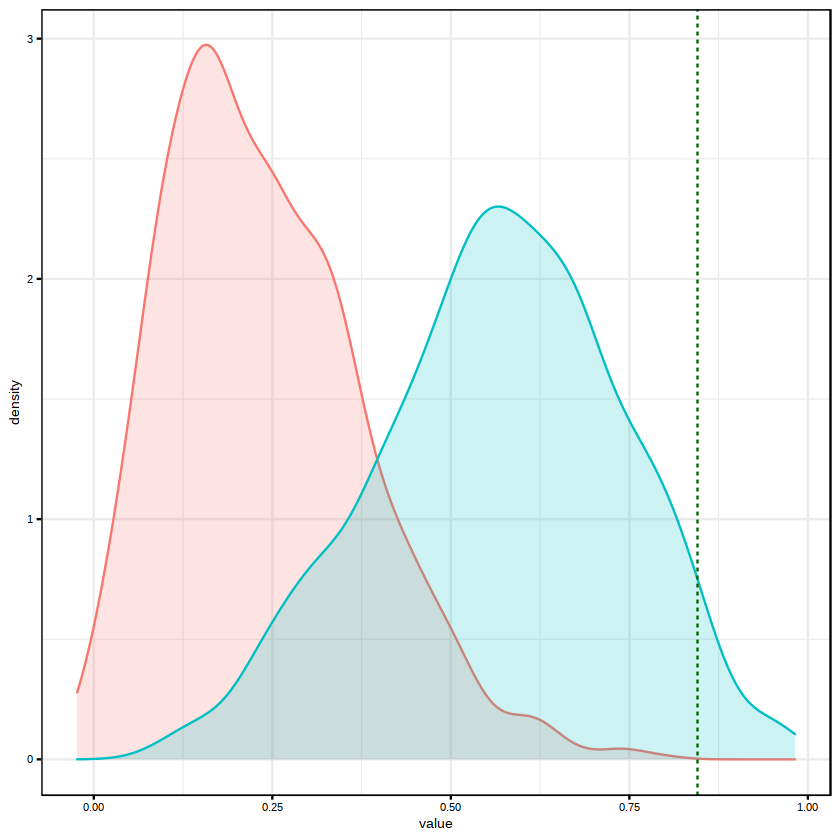

In [5]:
sim_df_m %>% 
    ggplot(aes(x=value,color=variable,fill=variable)) + 
    geom_density(alpha = 0.2) +
    geom_vline(xintercept=0.8450, color = "dark green", lty=2) + 
    theme_alex() + theme(legend.position = "none")

In [4]:

pdf(file="plots/entangle_simulations.pdf",
        width=1.8,height=1.6, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

sim_df_m %>% 
    ggplot(aes(x=value,color=variable,fill=variable)) + 
    geom_density(alpha = 0.2) +
    geom_vline(xintercept=0.8450, color = "dark green", lty=2) + 
    theme_alex() + theme(legend.position = "none")

dev.off()

png 
  2

---
---
---
## SUBSET FOR FIG1

In [12]:
tmp <- cf_misc_covid
dds <- tmp[['dds']]
tmp[['dds']] <- dds[,colnames(dds) %in% c('prevail_cu_cfrna_293','prevail_cu_cfrna_298','prevail_cu_cfrna_192','prevail_cu_cfrna_235','prevail_cu_cfrna_236')]

[1] "prevail_cu_cfrna_293" "prevail_cu_cfrna_298" "prevail_cu_cfrna_301"
 [4] "prevail_cu_cfrna_308" "prevail_cu_cfrna_300" "prevail_cu_cfrna_304"
 [7] "prevail_cu_cfrna_305" "prevail_cu_cfrna_81"  "prevail_cu_cfrna_82" 
[10] "prevail_cu_cfrna_83"  "prevail_cu_cfrna_307" "prevail_cu_cfrna_313"
[13] "prevail_cu_cfrna_303" "prevail_cu_cfrna_310" "prevail_cu_cfrna_309"
[16] "prevail_cu_cfrna_290" "prevail_cu_cfrna_108" "prevail_cu_cfrna_294"
[19] "prevail_cu_cfrna_287" "prevail_cu_cfrna_282" "prevail_cu_cfrna_284"
[22] "prevail_cu_cfrna_285" "prevail_cu_cfrna_292" "prevail_cu_cfrna_24" 
[25] "prevail_cu_cfrna_296" "prevail_cu_cfrna_299" "prevail_cu_cfrna_42" 
[28] "prevail_cu_cfrna_171" "prevail_cu_cfrna_152" "prevail_cu_cfrna_174"
[31] "prevail_cu_cfrna_181" "prevail_cu_cfrna_183" "prevail_cu_cfrna_175"
[34] "prevail_cu_cfrna_179" "prevail_cu_cfrna_182" "prevail_cu_cfrna_191"
[37] "prevail_cu_cfrna_192" "prevail_cu_cfrna_235" "prevail_cu_cfrna_236"

class: DESeqDataSet 
dim: 56634 4 
metadata(1): version
assays(6): counts mu ... replaceCounts replaceCooks
rownames(56634): ENSG00000223972.5 ENSG00000227232.5 ...
  ENSG00000278625.1 ENSG00000277374.1
rowData names(26): gene_id gene_name ... maxCooks replace
colnames(4): prevail_cu_cfrna_293 prevail_cu_cfrna_298
  prevail_cu_cfrna_235 prevail_cu_cfrna_236
colData names(62): unique_sample_id PTID ... sizeFactor replaceable

In [27]:
###----------------------------------
# MIS-C and COVID
set.seed(42)
tmp <- cf_misc_covid
dds <- tmp[['dds']]
keepers <- sample(colnames(dds),8)
tmp[['dds']] <- dds[,colnames(dds) %in% keepers]

dendlist <- make_dend_list(tmp, wb_misc_covid, 
                           cf_meta, wb_meta,
                           cf_ftcounts,wb_ftcounts,
                           PVAL_THRESH = PVAL_THRESH, LOGFC_THRESH = LOGFC_THRESH)

bg_cor <- cor_bakers_gamma(dendlist[[1]],dendlist[[2]])
pval <- get_pval(dendlist,bg_cor,1000)

print(bg_cor)
print(pval)

HEIGHT = 1
WIDTH = 1

pdf(file="plots/entangle_FIG1.pdf",
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

dendlist %>% 
    tanglegram(intersecting= TRUE,
               color_lines = "black",
            margin_inner = 0.1,
             highlight_branches_lwd = FALSE,
             highlight_distinct_edges = FALSE,
             lwd = 1,
               edge.lwd = 1,
             margin_top=0,
             margin_bottom = 0)

dev.off()

[1] 0.1386981
[1] 0.219


png 
  2

In [31]:
pdf(file="plots/entangle_FIG1.pdf",
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

dendlist %>% 
    tanglegram(intersecting= TRUE,
               color_lines = "black",
            margin_inner = 0.1,
             highlight_branches_lwd = FALSE,
             highlight_distinct_edges = FALSE,
             lwd = 1,
               edge.lwd = 1,
             margin_top=0,
             margin_bottom = 0)

dev.off()

png 
  2

---
---
---
# OLD

---
---
---
# MIS-C vs COVID-19

#### Read in data and create dendograms

In [40]:
# MISC vs COVID

cf_tmp_rds <- cf_misc_covid
wb_tmp_res <- wb_misc_covid

#----------------------------------------
## Cell-free
IDS_cf <- colnames(cf_tmp_rds[['dds']])

sig_genes_cf <- data.frame(cf_tmp_rds[['res']]) %>% filter(padj < PVAL_THRESH & abs(log2FoldChange) > LOGFC_THRESH) %>% rownames()
cf_dendL = get_dend(IDS_cf,sig_genes_cf,cf_meta,cf_ftcounts)

#----------------------------------------
## Whole blood
wb_tmp_res$ensmbl <- lapply(wb_tmp_res$gene,get_gene_id,annotation)

cf_pt_dates <- cf_meta %>% filter(cfrna_sample_id %in% all_of(IDS_cf)) %>% pull(PTID_DATE)

IDS_wb <- wb_meta %>% 
    filter(PTID_DATE %in% all_of(cf_pt_dates)) %>% 
    pull(SEQ_ID..UCSFonly.)

sig_genes_wb <- wb_tmp_res %>% filter(padj < PVAL_THRESH & abs(log2FoldChange) > LOGFC_THRESH) %>% pull(ensmbl)
wb_dendL = get_dend(IDS_wb,sig_genes_wb,wb_meta,wb_ftcounts)

In [52]:
K_clus = 1

cf_d <- cf_dendL %>% ladderize %>%  set("branches_k_color", value = 1:K_clus, k = K_clus)
wb_d <- wb_dendL %>% ladderize %>%   set("branches_k_color", value = 1:K_clus, k = K_clus)

cf_d <- cf_dendL %>% set("branches_k_color", value = 1:K_clus, k = K_clus)
wb_d <- wb_dendL %>% set("branches_k_color", value = 1:K_clus, k = K_clus)


## Get labels and clusters
cf_d_grps <- cf_d  %>% cutree(k=K_clus)
cf_d_labs <- cf_d %>% labels
cf_d_grps <- cf_d_grps[cf_d_labs]

wb_d_grps <- wb_d  %>% cutree(k=K_clus)
wb_d_labs <- wb_d %>% labels
wb_d_grps <- wb_d_grps[wb_d_labs]

# m_cntrl_grps = ifelse(m_cntrl_grps == 2,3,ifelse(m_cntrl_grps == 1,2,ifelse(m_cntrl_grps == 3,1,4)))


FINAL_COLORS <- c()
for (n in names(cf_d_grps)){
    if (n %in% names(wb_d_grps)){
    if (wb_d_grps[[n]] != wb_d_grps[[n]]){
        FINAL_COLORS <- c(FINAL_COLORS,"grey")
    } else{FINAL_COLORS <- c(FINAL_COLORS,cf_d_grps[[n]])} }
    
}

# FINAL_COLORS <- ifelse(FINAL_COLORS == '4','2',ifelse(FINAL_COLORS == '1', '4',ifelse(FINAL_COLORS == '2', '3',ifelse(FINAL_COLORS == '3', '1',FINAL_COLORS))))

dendlist <- dendlist(cf_d,wb_d)

HEIGHT = 1
WIDTH = 3.65

pdf(file="plots/entangle_misc-covid.pdf",
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

dendlist %>% 
    tanglegram(intersecting= TRUE,color_lines = FINAL_COLORS,
                           margin_inner = 0.1,
             highlight_branches_lwd = FALSE,
             highlight_distinct_edges = FALSE,
             lwd = 0.5,
               edge.lwd = 0.8,
             margin_top=0,
             margin_bottom = 2) %>%
    untangle(method = "step1side")

dev.off()

$dend1
'dendrogram' with 2 branches and 39 members total, at height 1.644543 

$dend2
'dendrogram' with 2 branches and 39 members total, at height 1.591252 

attr(,"class")
[1] "dendlist"

png 
  2

In [73]:
bg_cor <- cor_bakers_gamma(cf_d,wb_d)

print(bg_cor)
get_pval(dendlist,bg_cor,1000)
# get_conf(dendlist,bg_cor,100)

[1] 0.2428199


[1] 0.001

---
---
---
# MIS-C vs CONTROL

#### Read in data and create dendograms

In [88]:
# MISC vs CONTROL

cf_tmp_rds <- cf_misc_cntrl
wb_tmp_res <- wb_misc_cntrl

#----------------------------------------
## Cell-free
IDS_cf <- colnames(cf_tmp_rds[['dds']])

sig_genes_cf <- data.frame(cf_tmp_rds[['res']]) %>% filter(padj < PVAL_THRESH & abs(log2FoldChange) > LOGFC_THRESH) %>% rownames()
cf_dendL = get_dend(IDS_cf,sig_genes_cf,cf_meta,cf_ftcounts)

#----------------------------------------
## Whole blood
wb_tmp_res$ensmbl <- lapply(wb_tmp_res$gene,get_gene_id,annotation)

cf_pt_dates <- cf_meta %>% filter(cfrna_sample_id %in% all_of(IDS_cf)) %>% pull(PTID_DATE)

IDS_wb <- wb_meta %>% 
    filter(PTID_DATE %in% all_of(cf_pt_dates)) %>% 
    pull(SEQ_ID..UCSFonly.)

sig_genes_wb <- wb_tmp_res %>% filter(padj < PVAL_THRESH & abs(log2FoldChange) > LOGFC_THRESH) %>% pull(ensmbl)
wb_dendL = get_dend(IDS_wb,sig_genes_wb,wb_meta,wb_ftcounts)

In [89]:
K_clus = 1

cf_d <- cf_dendL %>% ladderize %>%  set("branches_k_color", value = 1:K_clus, k = K_clus)
wb_d <- wb_dendL %>% ladderize %>%   set("branches_k_color", value = 1:K_clus, k = K_clus)

cf_d <- cf_dendL %>% set("branches_k_color", value = 1:K_clus, k = K_clus)
wb_d <- wb_dendL %>% set("branches_k_color", value = 1:K_clus, k = K_clus)


## Get labels and clusters
cf_d_grps <- cf_d  %>% cutree(k=K_clus)
cf_d_labs <- cf_d %>% labels
cf_d_grps <- cf_d_grps[cf_d_labs]

wb_d_grps <- wb_d  %>% cutree(k=K_clus)
wb_d_labs <- wb_d %>% labels
wb_d_grps <- wb_d_grps[wb_d_labs]

# m_cntrl_grps = ifelse(m_cntrl_grps == 2,3,ifelse(m_cntrl_grps == 1,2,ifelse(m_cntrl_grps == 3,1,4)))


FINAL_COLORS <- c()
for (n in names(cf_d_grps)){
    if (n %in% names(wb_d_grps)){
    if (wb_d_grps[[n]] != wb_d_grps[[n]]){
        FINAL_COLORS <- c(FINAL_COLORS,"grey")
    } else{FINAL_COLORS <- c(FINAL_COLORS,cf_d_grps[[n]])} }
    
}

# FINAL_COLORS <- ifelse(FINAL_COLORS == '4','2',ifelse(FINAL_COLORS == '1', '4',ifelse(FINAL_COLORS == '2', '3',ifelse(FINAL_COLORS == '3', '1',FINAL_COLORS))))


HEIGHT = 1
WIDTH = 3.65

pdf(file="plots/entangle_misc-control.pdf",
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "cmyk", pointsize=6, useDingbats = FALSE)

dendlist(cf_d,wb_d) %>% 
    tanglegram(intersecting= TRUE,color_lines = FINAL_COLORS,
                           margin_inner = 0.1,
             highlight_branches_lwd = FALSE,
             highlight_distinct_edges = FALSE,
             lwd = 0.5,
               edge.lwd = 0.8,
             margin_top=0,
             margin_bottom = 2) %>%
    untangle(method = "step1side") %>%
    entanglement() 


dev.off()

[1] 0.2542361

png 
  2

In [87]:
dend_intersected <- intersect_trees(cf_d, wb_d)

d1 <- dend_intersected[[1]]
d2 <- dend_intersected[[2]]

cor_bakers_gamma(d1,d2)

[1] 0.4351013

---
---
---
# COVID-19 vs CONTROL

#### Read in data and create dendograms

In [92]:
# COVID vs CONTROL

cf_tmp_rds <- cf_covid_cntrl
wb_tmp_res <- wb_covid_cntrl


#----------------------------------------
## Cell-free

IDS_cf <- colnames(cf_tmp_rds[['dds']])

sig_genes_cf <- data.frame(cf_tmp_rds[['res']]) %>% filter(padj < PVAL_THRESH & abs(log2FoldChange) > LOGFC_THRESH) %>% rownames()
cf_dendL = get_dend(IDS_cf,sig_genes_cf,cf_meta,cf_ftcounts)

#----------------------------------------
## Whole blood
wb_tmp_res$ensmbl <- lapply(wb_tmp_res$gene,get_gene_id,annotation)

cf_pt_dates <- cf_meta %>% filter(cfrna_sample_id %in% all_of(IDS_cf)) %>% pull(PTID_DATE)

IDS_wb <- wb_meta %>% 
    filter(PTID_DATE %in% all_of(cf_pt_dates)) %>% 
    pull(SEQ_ID..UCSFonly.)

sig_genes_wb <- wb_tmp_res %>% filter(padj < PVAL_THRESH & abs(log2FoldChange) > LOGFC_THRESH) %>% pull(ensmbl)
wb_dendL = get_dend(IDS_wb,sig_genes_wb,wb_meta,wb_ftcounts)

In [94]:
K_clus = 1

cf_d <- cf_dendL %>% ladderize %>%  set("branches_k_color", value = 1:K_clus, k = K_clus)
wb_d <- wb_dendL %>% ladderize %>%   set("branches_k_color", value = 1:K_clus, k = K_clus)

cf_d <- cf_dendL %>% set("branches_k_color", value = 1:K_clus, k = K_clus)
wb_d <- wb_dendL %>% set("branches_k_color", value = 1:K_clus, k = K_clus)


## Get labels and clusters
cf_d_grps <- cf_d  %>% cutree(k=K_clus)
cf_d_labs <- cf_d %>% labels
cf_d_grps <- cf_d_grps[cf_d_labs]

wb_d_grps <- wb_d  %>% cutree(k=K_clus)
wb_d_labs <- wb_d %>% labels
wb_d_grps <- wb_d_grps[wb_d_labs]

# m_cntrl_grps = ifelse(m_cntrl_grps == 2,3,ifelse(m_cntrl_grps == 1,2,ifelse(m_cntrl_grps == 3,1,4)))


FINAL_COLORS <- c()
for (n in names(cf_d_grps)){
    if (n %in% names(wb_d_grps)){
    if (wb_d_grps[[n]] != wb_d_grps[[n]]){
        FINAL_COLORS <- c(FINAL_COLORS,"grey")
    } else{FINAL_COLORS <- c(FINAL_COLORS,cf_d_grps[[n]])} }
    
}

# FINAL_COLORS <- ifelse(FINAL_COLORS == '4','2',ifelse(FINAL_COLORS == '1', '4',ifelse(FINAL_COLORS == '2', '3',ifelse(FINAL_COLORS == '3', '1',FINAL_COLORS))))


HEIGHT = 1
WIDTH = 3.65

pdf(file="plots/entangle_covid-control.pdf",
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "cmyk", pointsize=6, useDingbats = FALSE)

dendlist(cf_d,wb_d) %>% 
    tanglegram(intersecting= TRUE,color_lines = FINAL_COLORS,
                           margin_inner = 0.1,
             highlight_branches_lwd = FALSE,
             highlight_distinct_edges = FALSE,
             lwd = 0.5,
               edge.lwd = 0.8,
             margin_top=0,
             margin_bottom = 2) %>%
    untangle(method = "step1side") %>%
    entanglement() 


dev.off()

[1] 0.1595751

png 
  2

In [95]:
t1 <- dendlist(cf_d,wb_d)
dend_intersected <- intersect_trees(t1[[1]],t1[[2]])

d1 <- dend_intersected[[1]]
d2 <- dend_intersected[[2]]

cor_bakers_gamma(d1,d2)

[1] 0.6353405

---
---
---
# Subsampling

In [ ]:
get_hclust <- function(IDS,sig_genes,meta,ftcounts){
    ANNOTATIONS <- c("Diagnosis","severity",'pcr_positive_MC_1yes','antibody_positive_MC_1yes','kd_like_MC_1yes','req_vasopressors_inotropes_MC_1yes')

    if (is.null(meta$cfrna_file_id)) {meta$cfrna_file_id <- meta$SEQ_ID..UCSFonly.}
    
    metadata <- meta %>% 
    filter(cfrna_file_id %in% all_of(IDS)) %>%                                 ###
    mutate(PTID_DATE = gsub("-","\\.",PTID_DATE)) %>%
    column_to_rownames(var = "cfrna_file_id") %>%  
    mutate(severity = ifelse(grepl("ontrol",severity),NA,severity)) %>%
    select(all_of(ANNOTATIONS))

    colnames(metadata) <- c("Diagnosis","Severity","PCR","Antibody")

    ###----------------------------------
    ## Subset count matrix
    mat <- data.frame(ftcounts) %>% 
            filter(row.names(ftcounts) %in% all_of(sig_genes)) %>% 
            select(all_of(rownames(metadata))) %>% 
            as.matrix()

    mat <- t(scale(t(mat)))

    ###----------------------------------
    ## Perform clustering

    h <- hclust(as.dist(1 - cor(mat, method = "pearson", use = 'pairwise.complete.obs')))
    return(h)
}

In [27]:
make_hist <- function(cf_tmp_rds,wb_tmp_res,N=0){

    ## Cell-free
    IDS_cf <- colnames(cf_tmp_rds[['dds']])
    
    if (N>0){IDS_cf <- sample(IDS_cf,N)}
    cf_pt_dates <- cf_meta %>% filter(cfrna_sample_id %in% all_of(IDS_cf)) %>% pull(PTID_DATE)
    IDS_wb <- wb_meta %>% 
        filter(PTID_DATE %in% all_of(cf_pt_dates)) %>% 
        pull(SEQ_ID..UCSFonly.)
    

    sig_genes_cf <- data.frame(cf_tmp_rds[['res']]) %>% filter(padj < PVAL_THRESH & abs(log2FoldChange) > LOGFC_THRESH) %>% rownames()
    cf_dendL = get_dend(IDS_cf,sig_genes_cf,cf_meta,cf_ftcounts)

    #----------------------------------------
    ## Whole blood
    wb_tmp_res$ensmbl <- lapply(wb_tmp_res$gene,get_gene_id,annotation)


    sig_genes_wb <- wb_tmp_res %>% filter(padj < PVAL_THRESH & abs(log2FoldChange) > LOGFC_THRESH) %>% pull(ensmbl)
    wb_dendL = get_dend(IDS_wb,sig_genes_wb,wb_meta,wb_ftcounts)

    
    return(dendlist(cf_dendL,wb_dendL))
    
}


make_tanglegram <- function(dend_ext_object){

    #----------------------------------------
    ## PLOT
    PLOT <- dend_ext_object %>% 
    tanglegram(intersecting= TRUE,color_lines = FINAL_COLORS,
                           margin_inner = 0.1,
             highlight_branches_lwd = FALSE,
             highlight_distinct_edges = FALSE,
             lwd = 0.5,
               edge.lwd = 0.8,
             margin_top=0,
             margin_bottom = 2) %>%
    untangle(method = "step1side") 
    
    return(PLOT)
    
}

calc_bakers_gamma <- function(dend_ext_object){

    dend_intersected <- intersect_trees(dend_ext_object[[1]], dend_ext_object[[2]])

    d1 <- dend_intersected[[1]]
    d2 <- dend_intersected[[2]]

    cor_bakers_gamma(d1,d2)

}



In [28]:
output_misc_covid <- c()
output_misc_cntrl <- c()


for (n in c(1:10)){

    NUM_SAMP = 26

    output <- make_hist(cf_misc_covid, wb_misc_covid, N=NUM_SAMP)
    output_misc_covid <- c(output_misc_covid,calc_bakers_gamma(output))
    
    
    output <- make_hist(cf_misc_cntrl, wb_misc_cntrl, N=NUM_SAMP)
    output_misc_cntrl <- c(output_misc_cntrl,calc_bakers_gamma(output))

}

df <- data.frame(output_misc_covid, output_misc_cntrl)
write.table(df, "./simulation_bakers_gamma.tsv",sep="\t",row.names=FALSE)

In [29]:
write.table(df, "./simulation_bakers_gamma.tsv",sep="\t",row.names=FALSE)

---
---

In [5]:
sim_df <- read.delim("./simulation_bakers_gamma.tsv")
colnames(sim_df) <- c("MIS-C_vs_COVID-19","MIS-C_vs_Control")
sim_df_m <- melt(sim_df)
sim_df_m %>% head()

No id variables; using all as measure variables



,variable,value
,<fct>,<dbl>
1,MIS-C_vs_COVID-19,0.14523997
2,MIS-C_vs_COVID-19,0.05259711
3,MIS-C_vs_COVID-19,0.22193138
4,MIS-C_vs_COVID-19,0.62871180
5,MIS-C_vs_COVID-19,0.04925115
6,MIS-C_vs_COVID-19,0.19557530


In [8]:
sim_df %>% head()

,MIS-C_vs_COVID-19,MIS-C_vs_Control
,<dbl>,<dbl>
1,0.14523997,0.6145611
2,0.05259711,0.3419511
3,0.22193138,0.7096079
4,0.62871180,0.1779282
5,0.04925115,0.5802399
6,0.19557530,0.6074346


In [9]:
source("~//theme_alex.R")

In [12]:
pdf(file="plots/entangle_simulations.pdf",
        width=1.8,height=1.6, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

sim_df_m %>% 
    ggplot(aes(x=value,color=variable,fill=variable)) + 
    geom_density(alpha = 0.2) +
    geom_vline(xintercept=0.8450, color = "dark green", lty=2) + 
    theme_alex() + theme(legend.position = "none")

dev.off()

png 
  2

In [6]:
summary(sim_df_m$value)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.02331  0.21145  0.38209  0.40227  0.58034  0.98193 

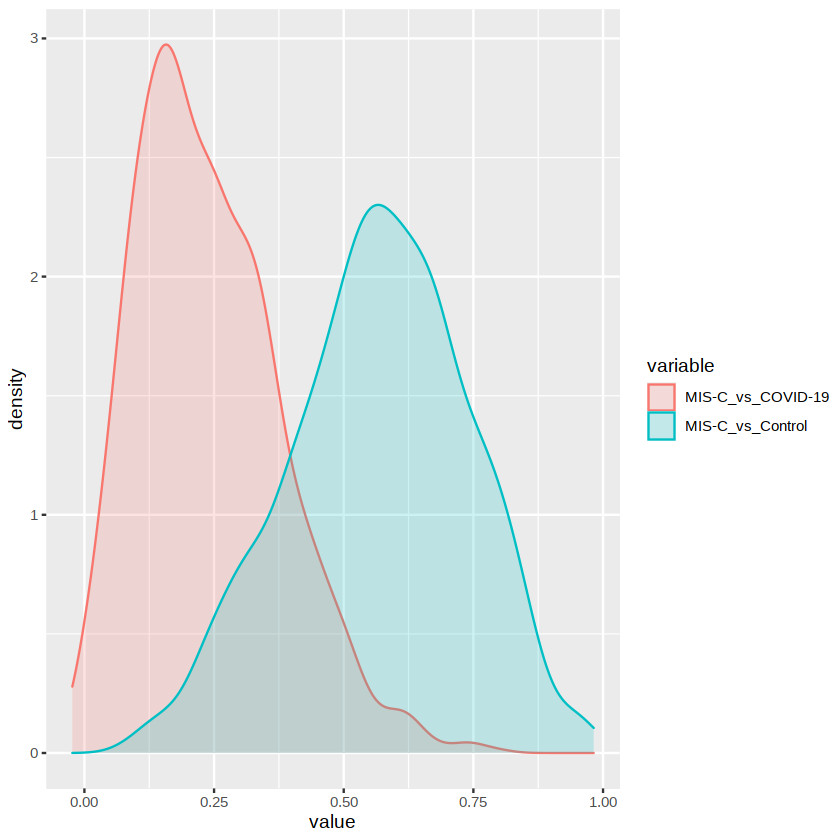

In [7]:
sim_df_m %>% 
    ggplot(aes(x=value,color=variable,fill=variable)) + 
    geom_density(alpha = 0.2) 